# Laboratorul 6 - Segmentare Semantica

## Intro 

Task-ul pentru acest laborator consta in implementarea si antrenarea unei retele complet convolutionale ([Fully Convolutional Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf)) folosita pentru segmentarea semantica a imaginilor (clasificare la nivel de pixel). 

Tema voastra este sa implementati cele 3 variante ale arhitecturii (FCN-32s, FCN-16s si FCN-8s) si sa antrenati retelele pentru a clasifica fiecare pixel din imagine. Pentru aceste exercitii se va folosi detul de date [Kitti Road](http://www.cvlibs.net/datasets/kitti/eval_road.php), unde scopul este sa obtinem segmentarea semantica a drumurilor. 



## De ce FCN?

O retea convolutionala normala consta dintr-o serie de straturi convolutionale, urmata de straturi fully connected si, in cele din urma, de o functie de activare Softmax. Aceasta este o arhitectura buna pentru clasificare, insa straturile fully connected nu pastreaza informatia spatiala. Avantajul retelei FCN este ca aceasta pastreaza informatia spatiala in intreaga retea (FCN functioneaza cu imagini de orice dimensiune).

Din punct de vedere structural, FCN este compusa din doua parti: encoder (blocuri de downsampling - [VGG](https://arxiv.org/pdf/1409.1556.pdf))  si decoder (blocuri de upsampling - o arhitectura "skip" care combina informatie semantica globala (din ultimele straturi "deep" ale retelei) cu informatii de aspect (mai fine, din layerele mai "shallow") pentru a produce segmentari cat mai precise si detaliate). 
Segmentarea semantică se confruntă cu o tensiune inerentă între semantică și locație: informațiile globale rezolva problema clasei - "CE" (clasificare in cazul mai multor clase semantice), în timp ce informațiile locale rezolvă "UNDE". 

---

![alt text](https://www.researchgate.net/publication/324787148/figure/fig4/AS:619840926670848@1524793001425/FCN-VGG16-network-with-skip-architecture.png)

##Descarcarea setului de date 

In [1]:
!mkdir ./data ./runs ./saved_models
# Download and unzip the dataset
!wget --progress=bar:force https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip -P ./data
!unzip -q ./data/data_road.zip -d ./data

--2022-04-06 11:45:39--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.47.179
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.47.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 470992343 (449M) [application/zip]
Saving to: ‘./data/data_road.zip’

data_road.zip       100%[===================>] 449.17M  27.3MB/s    in 18s     

2022-04-06 11:45:57 (25.3 MB/s) - ‘./data/data_road.zip’ saved [470992343/470992343]



# Pregatirea setului de date

In celula de mai jos sunt implementate clasele de tipul torch.utils.data.Dataset ce vor fi folosite pentru a itera prin seturile de date de antrenare si de test din Kitti Road Segmentation. 

De asemenea sunt implementate doua functii *collate_fn()* una pentru antrenare ce returneaza si imagini si adnotari, si una pentru testare ce returneaza doar imagini.

In final sunt instantiate 3 obiecte torch.utils.data.DataLoader: unul pentru antrenare, unul pentru testare si unul pentru vizualizare.




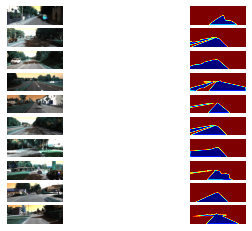

In [2]:
import os
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import normalize, to_tensor

%matplotlib inline

TRAIN_IMAGES_PATH = "./data/data_road/training/image_2"
TRAIN_LABELS_PATH = "./data/data_road/training/gt_image_2"
TEST_IMAGES_PATH = "./data/data_road/testing/image_2"


def collate_fn_train(examples):

  images = []
  labels = []
  for example in examples:
    image, label = example

    image = to_tensor(image)
    image = normalize(image, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # normalize the image tensor to [-1, 1] on each channel: img_norm = (img - data_mean) / data_std 
    image = image.unsqueeze(0) 
    label = torch.tensor(label).unsqueeze(0)
    images.append(image)
    labels.append(label)
  
  images_batch = torch.cat(images)
  labels_batch = torch.cat(labels)

  return images_batch, labels_batch

def collate_fn_test(examples):
  images = []
  for example in examples:
    image = example
    image = to_tensor(image)
    image = normalize(image, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # on test set we apply the same normalization 
    image = image.unsqueeze(0)
    images.append(image)

  images_batch = torch.cat(images)

  return images_batch

class KittiImageDataset(Dataset):

  def __init__(self, images_root, original_shape=(1242, 375) ,
               load_shape=(384, 128)):
    self.images_root = images_root
    self.original_shape = original_shape
    self.load_shape = load_shape
    self.images = list(sorted(glob.glob(os.path.join(TRAIN_IMAGES_PATH ,'*'))))

  def __getitem__(self, idx):
    image = cv2.imread(self.images[idx])
    image = cv2.resize(image, self.load_shape)

    return image

  def __len__(self):
    return len(self.images)

class KittiTrainDataset(KittiImageDataset):

  def __init__(self, images_root, labels_root, original_shape=(1242, 375) ,
               load_shape=(384, 128)):
    super(KittiTrainDataset, self).__init__(images_root, original_shape=original_shape, 
                                            load_shape=load_shape)
    self.labels_root = labels_root
    self.labels = list(sorted(glob.glob(os.path.join(TRAIN_LABELS_PATH, '*_road_*'))))

  def __getitem__(self, idx):
    image = super(KittiTrainDataset, self).__getitem__(idx)
    label = cv2.imread(self.labels[idx])
    label = cv2.resize(label, self.load_shape, interpolation=cv2.INTER_NEAREST)  # resize labels to same 'load_shape' as the image
    # Initially label images are RGB images with the following color code: the road (lane) as magenta, non-road areas as red and other road surfaces as black
    # For our project we are interested in black and magenta areas, so we will process the label images by summing over the channel dimension in order to obtain
    # a binary image, where "1" denotes background and "0" denotes the road areas. 
    new_label = label.sum(axis=2) 
    new_label = np.where(new_label == 255, 1, 0)
    
    return image, new_label

  def __len__(self):
    assert len(self.images) == len(self.labels)
    return len(self.images)

# Create train dataset object
train_dataset = KittiTrainDataset(TRAIN_IMAGES_PATH, TRAIN_LABELS_PATH)

# Create test dataset object
test_dataset = KittiImageDataset(TEST_IMAGES_PATH)

# Create dataloaders for visualization, train and test
vis_dataloader = DataLoader(train_dataset, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, 
                              num_workers=2, collate_fn=collate_fn_train)
test_dataloader = DataLoader(test_dataset, shuffle=True, collate_fn=collate_fn_test)


num_samples = 10 
vis_iter = iter(vis_dataloader)
for i in range(num_samples):
  image, label = vis_iter.next()
  image = image.squeeze(0).numpy()
  label = label.squeeze(0).numpy()
  plt.subplot(num_samples, 2, 2*i+1)
  plt.axis('off')
  plt.imshow(image, None)
  plt.subplot(num_samples, 2, 2*i+2)
  plt.axis('off')
  plt.imshow(label[:,:], 'jet')

# Implementarea Retelei FCN

Arhitectura contine:
 * un encoder VGG folosit pentru operatia de downsampling (este un exemplu excelent pentru transferul de cunoștințe (transfer learning) din rețele moderne de clasificare, cum ar fi VGG16, Alexnet, etc. pentru a efectua segmentarea semantică; acest encoder este initializat cu weight-urile preantrenate pe Imagenet).
 * una sau mai multe operatii de upsample (convolutii transposed)
 * skip connections intre blocurile de downsampling si upsampling

## Cerinta
Task-ul vostru este sa implementati cele 3 clase care reprezinta cele 3 variante ale FCN: FCN-32s, FCN-16s si FCN-8s. (asa cum se regaseste in imaginea de mai sus).



 **Hint:** 
  * Folositi imaginea de mai sus a arhitecturii ca referinta 
  * Folosind SelectiveSequential, putem extrage activari intermediare din encoder. Layer-ul '16' este MaxPool3, '23' este MaxPool4 iar '30' este MaxPool5 (corespunzator imaginii arhitecturii FCN)
  * Output-ul encoder-ului nostru este Maxpool5 (puteti ignora portiunea dintre conv6 si conv8, sunt necesare operatii extra pentru a transforma layere Fully-Connected in Convolutions - nu este in scopul acestui laborator)

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models.vgg import VGG


class FCN32s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)

        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)


class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)


class FCN8s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.relu(self.deconv2(score))            # size=(N, 256, x.H/8, x.W/8)
        score = self.bn2(score + x3)                      # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)


class FCNs(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)
        x2 = output['x2']  # size=(N, 128, x.H/4,  x.W/4)
        x1 = output['x1']  # size=(N, 64, x.H/2,  x.W/2)

        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)


class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output


ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


# if __name__ == "__main__":
batch_size, n_class, h, w = 10, 3, 128, 128

# test output size
vgg_model = VGGNet(requires_grad=True)
input = torch.autograd.Variable(torch.randn(batch_size, 3, 224, 224))
output = vgg_model(input)
assert output['x5'].size() == torch.Size([batch_size, 512, 7, 7])

fcn_model = FCN32s(pretrained_net=vgg_model, n_class=n_class)
input = torch.autograd.Variable(torch.randn(batch_size, 3, h, w))
output = fcn_model(input)
assert output.size() == torch.Size([batch_size, n_class, h, w])

fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
input = torch.autograd.Variable(torch.randn(batch_size, 3, h, w))
output = fcn_model(input)
assert output.size() == torch.Size([batch_size, n_class, h, w])

fcn_model = FCN8s(pretrained_net=vgg_model, n_class=n_class)
input = torch.autograd.Variable(torch.randn(batch_size, 3, h, w))
output = fcn_model(input)
assert output.size() == torch.Size([batch_size, n_class, h, w])

fcn_model = FCNs(pretrained_net=vgg_model, n_class=n_class)
input = torch.autograd.Variable(torch.randn(batch_size, 3, h, w))
output = fcn_model(input)
assert output.size() == torch.Size([batch_size, n_class, h, w])

print("Pass size check")


Pass size check


In [16]:

# test a random batch, loss should decrease
fcn_model = FCNs(pretrained_net=vgg_model, n_class=n_class)
criterion = nn.BCELoss()
optimizer = optim.SGD(fcn_model.parameters(), lr=1e-3, momentum=0.9)
input = torch.autograd.Variable(torch.randn(batch_size, 3, h, w))
y = torch.autograd.Variable(torch.randn(batch_size, n_class, h, w), requires_grad=False)
for iter in range(10):
    optimizer.zero_grad()
    output = fcn_model(input)
    output = nn.functional.sigmoid(output)
    loss = criterion(output, y)
    loss.backward()
    # print(loss.data)
    print("iter{}, loss {}".format(iter, loss.data))
    optimizer.step()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


iter0, loss 0.7327300310134888
iter1, loss 0.7326988577842712
iter2, loss 0.732639491558075
iter3, loss 0.7325549125671387
iter4, loss 0.7324478626251221
iter5, loss 0.7323205471038818
iter6, loss 0.7321751713752747
iter7, loss 0.7320136427879333
iter8, loss 0.7318378686904907
iter9, loss 0.7316492795944214


In [17]:
import torch
import torch.nn as nn
import torchvision.models as models

class SelectiveSequential(nn.Module):
  def __init__(self, to_select, modules_dict):
    """Helper class - pentru extragea activarilor intermediare"""
    super(SelectiveSequential, self).__init__()
    for key, module in modules_dict.items():
      self.add_module(key, module)
    self._to_select = to_select
  
  def forward(self, x):
    list = []
    for name, module in self._modules.items():
      x = module(x)
      if name in self._to_select:
        list.append(x)
    return list


class FCN(nn.Module):
  """Main FCN Class"""
  def __init__(self):
    """Constructor

    Encoder-ul folosit pentru aceasta arhitectura este VGG16. 
    Pentru a implementa skip connections vom avea nevoie de activari intermediare
    (dupa pool3, pool4 si ultimul layer convolutional al encoder-ului)
    """
    super(FCN, self).__init__()
    vgg16 = models.vgg16(pretrained=True) # Incarca VGG16 (pretrained) din torchvision
    vgg16_convs = list(vgg16.children())[:-2] # Eliminam layerele de care nu avem nevoie 

    # Cele 3 layers ale caror feature maps le vom folosi la skip-connections 
    self.encoder = SelectiveSequential(['16', '23', '30'], vgg16_convs[0]._modules)


class FCN32(FCN):
  def __init__(self):
    super(FCN32, self).__init__()
    #### Codul vostru
    # self.upsample32 = ... 
    
  def forward(self, img):
    # Extrageti feature-uri din encoder de la layerul corespunzator si treceti rezultatul prin layerul de upsample
    #### Codul vostru

    pass


class FCN16(FCN):
  def __init__(self, variant='None'):
    super(FCN16, self).__init__()
    #### Codul vostru
    # self.upsample2 = ...
    # self.upsample16 = ...

  def forward(self, img):
      pass


class FCN8(FCN):
  def __init__(self, variant='None'):
    super(FCN8, self).__init__()
    #### Codul vostru
    # self.upsample2 = ...
    # self.upsample4 = ...
    # self.upsample32 = ...
    
  def forward(self, img):
    #### Codul vostru
    pass

# Antrenarea retelei

In [22]:
fcn = FCN32s(pretrained_net=vgg_model, n_class=3).cuda()
stop = 0

import torch.optim as optim

num_epochs =  10#@param
learning_rate = 0.0003 #@param

# Initializam functia de loss
loss_fn = nn.CrossEntropyLoss()

# Initializam optimizatorul
optimizer = optim.Adam(fcn.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Antrenarea retelei
for epoch in range(num_epochs):
  for idx, (image, label) in enumerate(train_dataloader):
    pred = fcn(image.cuda())
    loss = loss_fn(pred, label.cuda())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if idx % 10 == 0:
      print("Epoch {} - Iter {} - Loss {}".format(epoch, idx, loss.item()))

Epoch 0 - Iter 0 - Loss 1.1871774196624756
Epoch 0 - Iter 10 - Loss 0.9258629679679871
Epoch 0 - Iter 20 - Loss 0.7662568688392639
Epoch 0 - Iter 30 - Loss 0.7389501929283142
Epoch 1 - Iter 0 - Loss 0.6234350204467773
Epoch 1 - Iter 10 - Loss 0.6042588353157043
Epoch 1 - Iter 20 - Loss 0.5447015166282654
Epoch 1 - Iter 30 - Loss 0.520238995552063
Epoch 2 - Iter 0 - Loss 0.473178505897522
Epoch 2 - Iter 10 - Loss 0.4334399402141571
Epoch 2 - Iter 20 - Loss 0.3641016483306885
Epoch 2 - Iter 30 - Loss 0.3621208369731903
Epoch 3 - Iter 0 - Loss 0.3892178535461426
Epoch 3 - Iter 10 - Loss 0.342062383890152
Epoch 3 - Iter 20 - Loss 0.2608683705329895
Epoch 3 - Iter 30 - Loss 0.2720237970352173
Epoch 4 - Iter 0 - Loss 0.22786252200603485
Epoch 4 - Iter 10 - Loss 0.2670140564441681
Epoch 4 - Iter 20 - Loss 0.2300630658864975
Epoch 4 - Iter 30 - Loss 0.18852108716964722
Epoch 5 - Iter 0 - Loss 0.19519110023975372
Epoch 5 - Iter 10 - Loss 0.24541841447353363
Epoch 5 - Iter 20 - Loss 0.1955478042

In [ ]:
for idx, (image, label) in enumerate(train_dataloader):
    pred = fcn(image.cuda())
    print(pred)
    break

# Rularea retelei pe setul de date de test si vizualizare

## Cerinta
 * Procesati iesirea retelei pentru a vizualiza masca de segmentare prezisa ca in celula pentru pregatirea setului de date.

**Hints**
 * Iesirea va fi un feature map de dimensiunea imaginii de intrare cu 2 canale.
 * Pentru fiecare pixel canalele trebuiesc transformate intr-o distributie de probabilitati (Softmax)
 * Transformati intr-o imagine cu un singur canal cu valori 255 pentru clasa 'road' si 0 pentru clasa 'background'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

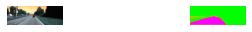

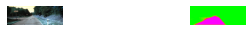

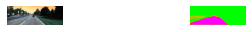

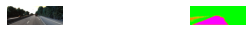

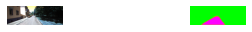

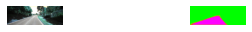

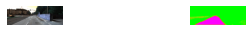

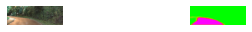

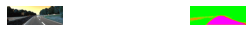

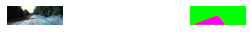

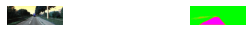

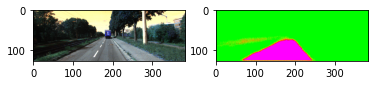

In [41]:
fcn.eval() # set model in eval mode

num_to_show = 10

softmax = nn.Softmax(dim=1)
# Ne asiguram ca nu se pot propaga gradienti prin retea
with torch.no_grad():
  for idx, image in enumerate(test_dataloader):

    if idx > num_to_show:
      break

    logits = fcn(image.cuda()) 

    # Postprocesarea imaginii pentru a fi vizualizata
    image = (image.squeeze(0).clone().cpu().numpy().transpose(1, 2, 0) + 1) / 2.0

    #### Codul vostru aici - postprocesarea iesirii retelei pentru a 
    #### fi vizualizata
    pred = (logits.clone().cpu().squeeze(0).numpy().transpose(1, 2, 0)+1)/2
      
    plt.subplot(num_samples, 2, 2*i+1)
    plt.axis('off')
    plt.imshow(image, None)
    plt.subplot(num_samples, 2, 2*i+2)
    plt.axis('off')
    plt.imshow(pred)
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(image)
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(pred)
    
    


Epoch 0 - Iter 0 - Loss 1.1024103164672852
Epoch 0 - Iter 10 - Loss 0.5999743342399597
Epoch 0 - Iter 20 - Loss 0.4296882450580597
Epoch 0 - Iter 30 - Loss 0.3412657678127289
Epoch 1 - Iter 0 - Loss 0.2966432571411133
Epoch 1 - Iter 10 - Loss 0.2632316052913666
Epoch 1 - Iter 20 - Loss 0.2860489785671234
Epoch 1 - Iter 30 - Loss 0.23562902212142944
Epoch 2 - Iter 0 - Loss 0.2332804650068283
Epoch 2 - Iter 10 - Loss 0.17716185748577118
Epoch 2 - Iter 20 - Loss 0.15825937688350677
Epoch 2 - Iter 30 - Loss 0.17054279148578644
Epoch 3 - Iter 0 - Loss 0.1654341220855713
Epoch 3 - Iter 10 - Loss 0.15103143453598022
Epoch 3 - Iter 20 - Loss 0.14461521804332733
Epoch 3 - Iter 30 - Loss 0.14383138716220856
Epoch 4 - Iter 0 - Loss 0.1218688115477562
Epoch 4 - Iter 10 - Loss 0.11672839522361755
Epoch 4 - Iter 20 - Loss 0.12411922216415405
Epoch 4 - Iter 30 - Loss 0.11274083703756332
Epoch 5 - Iter 0 - Loss 0.09686437249183655
Epoch 5 - Iter 10 - Loss 0.0994996652007103
Epoch 5 - Iter 20 - Loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

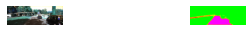

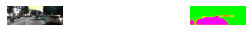

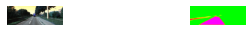

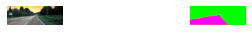

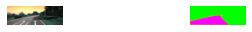

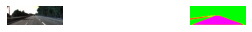

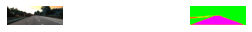

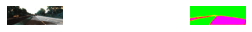

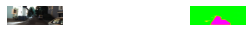

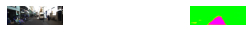

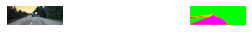

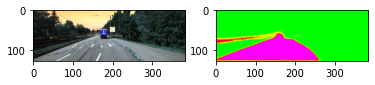

In [42]:
fcn = FCN16s(pretrained_net=vgg_model, n_class=3).cuda()
stop = 0

import torch.optim as optim

num_epochs =  10#@param
learning_rate = 0.0003 #@param

# Initializam functia de loss
loss_fn = nn.CrossEntropyLoss()

# Initializam optimizatorul
optimizer = optim.Adam(fcn.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Antrenarea retelei
for epoch in range(num_epochs):
  for idx, (image, label) in enumerate(train_dataloader):
    pred = fcn(image.cuda())
    loss = loss_fn(pred, label.cuda())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if idx % 10 == 0:
      print("Epoch {} - Iter {} - Loss {}".format(epoch, idx, loss.item()))

fcn.eval() # set model in eval mode

num_to_show = 10

softmax = nn.Softmax(dim=1)
# Ne asiguram ca nu se pot propaga gradienti prin retea
with torch.no_grad():
  for idx, image in enumerate(test_dataloader):

    if idx > num_to_show:
      break

    logits = fcn(image.cuda()) 

    # Postprocesarea imaginii pentru a fi vizualizata
    image = (image.squeeze(0).clone().cpu().numpy().transpose(1, 2, 0) + 1) / 2.0

    #### Codul vostru aici - postprocesarea iesirii retelei pentru a 
    #### fi vizualizata
    pred = (logits.clone().cpu().squeeze(0).numpy().transpose(1, 2, 0)+1)/2
      
    plt.subplot(num_samples, 2, 2*i+1)
    plt.axis('off')
    plt.imshow(image, None)
    plt.subplot(num_samples, 2, 2*i+2)
    plt.axis('off')
    plt.imshow(pred)
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(image)
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(pred)
    
    


Epoch 0 - Iter 0 - Loss 1.1291521787643433
Epoch 0 - Iter 10 - Loss 0.6352641582489014
Epoch 0 - Iter 20 - Loss 0.5192280411720276
Epoch 0 - Iter 30 - Loss 0.35909178853034973
Epoch 1 - Iter 0 - Loss 0.34804263710975647
Epoch 1 - Iter 10 - Loss 0.3500305116176605
Epoch 1 - Iter 20 - Loss 0.2975517809391022
Epoch 1 - Iter 30 - Loss 0.2836967408657074
Epoch 2 - Iter 0 - Loss 0.2515639364719391
Epoch 2 - Iter 10 - Loss 0.23483343422412872
Epoch 2 - Iter 20 - Loss 0.21665601432323456
Epoch 2 - Iter 30 - Loss 0.1997131109237671
Epoch 3 - Iter 0 - Loss 0.19883841276168823
Epoch 3 - Iter 10 - Loss 0.1962321251630783
Epoch 3 - Iter 20 - Loss 0.12923727929592133
Epoch 3 - Iter 30 - Loss 0.15665389597415924
Epoch 4 - Iter 0 - Loss 0.1199168935418129
Epoch 4 - Iter 10 - Loss 0.12937228381633759
Epoch 4 - Iter 20 - Loss 0.13204002380371094
Epoch 4 - Iter 30 - Loss 0.1321650892496109
Epoch 5 - Iter 0 - Loss 0.10260921716690063
Epoch 5 - Iter 10 - Loss 0.11723651736974716
Epoch 5 - Iter 20 - Loss 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

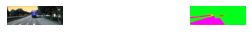

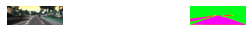

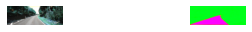

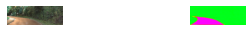

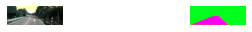

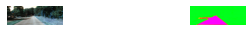

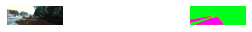

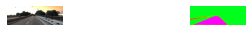

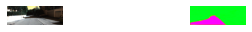

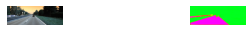

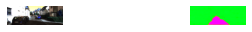

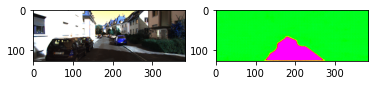

In [43]:
fcn = FCN8s(pretrained_net=vgg_model, n_class=3).cuda()
stop = 0

import torch.optim as optim

num_epochs =  10#@param
learning_rate = 0.0003 #@param

# Initializam functia de loss
loss_fn = nn.CrossEntropyLoss()

# Initializam optimizatorul
optimizer = optim.Adam(fcn.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Antrenarea retelei
for epoch in range(num_epochs):
  for idx, (image, label) in enumerate(train_dataloader):
    pred = fcn(image.cuda())
    loss = loss_fn(pred, label.cuda())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if idx % 10 == 0:
      print("Epoch {} - Iter {} - Loss {}".format(epoch, idx, loss.item()))

fcn.eval() # set model in eval mode

num_to_show = 10

softmax = nn.Softmax(dim=1)
# Ne asiguram ca nu se pot propaga gradienti prin retea
with torch.no_grad():
  for idx, image in enumerate(test_dataloader):

    if idx > num_to_show:
      break

    logits = fcn(image.cuda()) 

    # Postprocesarea imaginii pentru a fi vizualizata
    image = (image.squeeze(0).clone().cpu().numpy().transpose(1, 2, 0) + 1) / 2.0

    #### Codul vostru aici - postprocesarea iesirii retelei pentru a 
    #### fi vizualizata
    pred = (logits.clone().cpu().squeeze(0).numpy().transpose(1, 2, 0)+1)/2
      
    plt.subplot(num_samples, 2, 2*i+1)
    plt.axis('off')
    plt.imshow(image, None)
    plt.subplot(num_samples, 2, 2*i+2)
    plt.axis('off')
    plt.imshow(pred)
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(image)
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(pred)
    
    
